In [52]:
import pandas as pd
import pdb
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
#from sklearn.manifold import MDS 
from sklearn.cluster import KMeans
import itertools
from sklearn.metrics import silhouette_samples, silhouette_score
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [53]:
#data  = pd.read_csv("data/featureslogfile_Budget_2000_Budget_2000_GPM_100_NoSelfPlay.txt", sep = '\t')
data  = pd.read_csv("data/2Player_FG1E_Supply_AllYears_Traces_withScore_v2.txt", sep = ' ')
print(data)
print(data.columns)

      GameID   AgentName  Player  Round  FinalScore  Win  Cellar  Market  \
0          0  Silvermink       0      0          33  1.0       0       0   
1          0     Draggor       1      0          21  0.0       1       0   
2          0  Silvermink       0      1          33  1.0       1       0   
3          0     Draggor       1      1          21  0.0       1       1   
4          0  Silvermink       0      2          33  1.0       1       0   
...      ...         ...     ...    ...         ...  ...     ...     ...   
6433     148     mazungu       1     14          25  0.0       1       2   
6434     148     mazgirl       0     15          31  1.0       1       1   
6435     148     mazungu       1     15          25  0.0       1       2   
6436     148     mazgirl       0     16          31  1.0       1       1   
6437     148     mazungu       1     16          25  0.0       1       2   

      Militia  Mine  ...  Village  Woodcutter  Workshop  Curse  Gold  Silver  \
0      

In [54]:
LOGS_FROM_TAG = False #if false, logs are from parsed online player logs
#LOGS_FROM_TAG = True

NOOFPLAYERS = 2 #note, keep this fixed and dont change it - we always assume there are only two players
agents = ['PlayerA', 'PlayerB']

#if using TAG, parameters for round robin tournament
agents = ['MCTS_A_Budget_1000', 'MCTS_B_Budget_1000'] #arbitrary labels for players (whether AI based or not)
games_per_matchup = 100
self_play = False
NoOfGames = 2 * games_per_matchup
if self_play == True:
    NoOfGames = 4 * games_per_matchup
    
#if not using TAG, determine no of games 
if LOGS_FROM_TAG == False:
    NoOfGames = data['GameID'].max()  + 1 #GameID starts at zero

(array([ 3., 11., 12.,  9., 23., 15., 13., 10., 15., 10.,  4.,  7.,  5.,
         2.,  2.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
        27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
        40., 41., 42., 43., 44.]),
 <BarContainer object of 30 artists>)

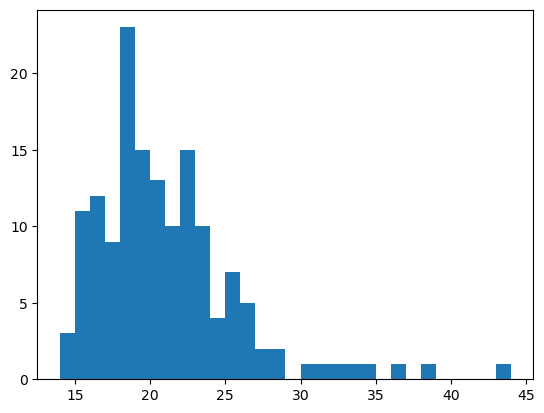

In [55]:
#what is the distribution of game length?
#round_data = pd.DataFrame()
if LOGS_FROM_TAG == False:
    #in this case need to figure out total rounds per game
    round_data = data.groupby('GameID')['Round'].max()
else:
    round_data = data['TotalRounds']
plt.hist(round_data, bins=np.arange(round_data.min(), round_data.max()+1))

(array([ 50.,   0.,  50.,  29.,  26.,  19.,   0.,  48.,   0.,   0.,  19.,
         46.,  50., 149.,  19.,  45.,  89.,  36.,  97., 365.,  55.,  86.,
        438., 202.,  81., 364., 148., 102., 373., 236., 122., 571., 165.,
         96., 293., 124., 120., 369., 267.,  20., 153.,  85.,   0., 265.,
         27.,  44., 164.,  49.,  39.,  24.,  37.,   0.,  24.,   0.,  45.,
         28.,   0.,  31.,   0.,  28.,  26.]),
 array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
        15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
        41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
        54., 55., 56., 57., 58., 59., 60., 61., 62., 63.]),
 <BarContainer object of 61 artists>)

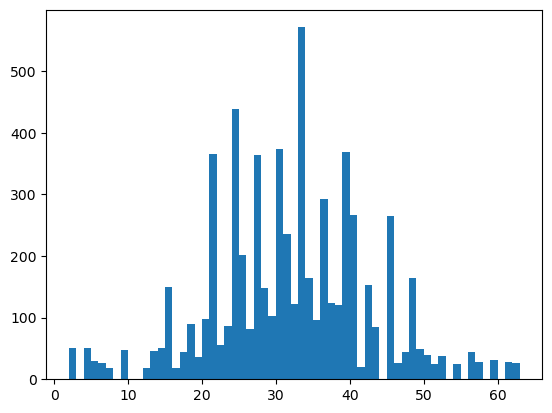

In [56]:
#what is the score distribution?
plt.hist(data['FinalScore'], bins=np.arange(data['FinalScore'].min(), data['FinalScore'].max()+1))

In [57]:
#label all games with corresponding agent names

if LOGS_FROM_TAG == True:
    #first generate match-ups
    matchups = []
    if self_play:
        for agent1 in agents:
            for agent2 in agents:
                matchups.append((agent1, agent2))
    else:
        matchups = list(itertools.permutations(agents, 2))

    #function to map gameID to match-up
    def gameID_to_matchup(game_id, player_no, matchup_list, no_games_per_matchup, min_game_id):
        game_group = int((game_id - min_game_id)/no_games_per_matchup)
        matchup = matchup_list[game_group]
        agent1, agent2 = matchup
        if player_no == 0:
            return agent1
        else:
            return agent2

    #add agent names to data set
    min_GameID = data['GameID'].min()
    data['AgentName'] = data.apply(lambda row: gameID_to_matchup(row['GameID'], row['Player'], matchups, games_per_matchup, min_GameID), axis = 1)                         

In [58]:
#define columns of interest 
#card_types_BigMoneyWithGardens_vs_DoubleWitch = ['GARDENS', 'WITCH', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_SD = ['ARTISAN', 'BANDIT', 'BUREAUCRAT', 'CHAPEL', 'FESTIVAL', 'GARDENS', 'SENTRY', 'THRONE_ROOM', 'WITCH',
                 'WORKSHOP', 'CURSE', 'PROVINCE', 'DUCHY', 'ESTATE', 'GOLD', 'SILVER', 'COPPER']
card_types_FG1E = ['Cellar','Market','Militia','Mine','Moat','Remodel','Smithy','Village',
                'Woodcutter','Workshop', 'Curse', 'Province', 'Duchy', 'Estate', 'Gold', 'Silver', 'Copper']
#card_types = card_types_SD 
card_types = card_types_FG1E
index_cols = ['Player', 'GameID'] #used to group traces
non_card_types_round_indep_cols = ['AgentName', 'Win', 'FinalScore'] #additional round indepedent values we want to investigate
cols = index_cols + non_card_types_round_indep_cols + ['Round'] + card_types #final set of cols to keep

In [10]:
#we seem to have an issue with some cards having their number reduced, which shouldn't happen in a BMWG vs DW set-up
#for card in card_types_BigMoneyWithGardens_vs_DoubleWitch:
#    for game in data['GameID'].unique():
#        for player in data['Player'].unique():
#            card_evol = data[(data['GameID'] == game) & (data['Player'] == player) & (data['Turn'] == 1)][card]
#            card_delta = card_evol - card_evol.shift(1)
#            if card_delta.min() < 0:
#                print("Issue with " + str(card) + " in game " + str(game) + " with player " + str(player))
                
#problem_trace = data[(data['GameID'] == 27) & (data['Player'] == 1)]['WITCH']
#print(problem_trace)

In [59]:
#we can only record events each turn so we need to use the final turn in each round for each player to determine their
#deck at the end of the round
if LOGS_FROM_TAG:
    print(data['Turn'].unique())
    data = data[data['Turn'] == 1]

In [60]:
#all play taces in a single data frame
traces = data.loc[:, cols]
print(traces)

      Player  GameID   AgentName  Win  FinalScore  Round  Cellar  Market  \
0          0       0  Silvermink  1.0          33      0       0       0   
1          1       0     Draggor  0.0          21      0       1       0   
2          0       0  Silvermink  1.0          33      1       1       0   
3          1       0     Draggor  0.0          21      1       1       1   
4          0       0  Silvermink  1.0          33      2       1       0   
...      ...     ...         ...  ...         ...    ...     ...     ...   
6433       1     148     mazungu  0.0          25     14       1       2   
6434       0     148     mazgirl  1.0          31     15       1       1   
6435       1     148     mazungu  0.0          25     15       1       2   
6436       0     148     mazgirl  1.0          31     16       1       1   
6437       1     148     mazungu  0.0          25     16       1       2   

      Militia  Mine  ...  Village  Woodcutter  Workshop  Curse  Province  \
0          

In [61]:
#we need to make sure all games have the same number of rounds in them
gameLengths = traces.groupby(['GameID'])['Round'].max()
maxNoOfRounds = int(gameLengths.max()) + 1 #round counter starts at zero
print(maxNoOfRounds)

45


In [62]:
def copy_final_deck_at_game_end(group, roundMax, noPlayers):
    #This function repeatedly copies the final decks of two players at the game end, so that the game is extended to 
    #have roundMax rounds
    final_round = int(group['Round'].max())
    if (roundMax-1) == final_round:
        #in this case we dont need to extend the play trace
        return group
    else:
        final_row_copy = pd.concat([group.iloc[-noPlayers:]] * ((roundMax-1) - final_round), ignore_index=True)
        #we need to update the Round counter so that every other row it increments by one
        final_row_copy['Round'] = [final_round + 1 + i // 2 for i in range(((roundMax-1) - final_round)*2)]
        return pd.concat([group, final_row_copy], ignore_index=True)

In [63]:
NoGamesDropped = 0
extended_traces = traces.groupby('GameID').apply(copy_final_deck_at_game_end, maxNoOfRounds, NOOFPLAYERS).reset_index(drop = True)
print(extended_traces)
print("Expected no rows: " + str(maxNoOfRounds*NOOFPLAYERS*(NoOfGames-NoGamesDropped)))
print("Expected no of cols: " + str(len(card_types)+6))
print(extended_traces.shape)

       Player  GameID   AgentName  Win  FinalScore  Round  Cellar  Market  \
0           0       0  Silvermink  1.0          33      0       0       0   
1           1       0     Draggor  0.0          21      0       1       0   
2           0       0  Silvermink  1.0          33      1       1       0   
3           1       0     Draggor  0.0          21      1       1       1   
4           0       0  Silvermink  1.0          33      2       1       0   
...       ...     ...         ...  ...         ...    ...     ...     ...   
13405       1     148     mazungu  0.0          25     42       1       2   
13406       0     148     mazgirl  1.0          31     43       1       1   
13407       1     148     mazungu  0.0          25     43       1       2   
13408       0     148     mazgirl  1.0          31     44       1       1   
13409       1     148     mazungu  0.0          25     44       1       2   

       Militia  Mine  ...  Village  Woodcutter  Workshop  Curse  Province  

In [96]:
#next we need to flatten this dataframe so that each trace is a single row.
#We also drop the round label as it is redundant
#and it will get reintroduced when flattening through the revised column names

#given a dictionary whose elements are lists of length two, grab the other element not given by elem, used in code
#below
def other_dict_element(my_dict, my_key, my_elem):
    index_of_given_element = my_dict[my_key].index(my_elem)
    index_of_other_element =  1 if (index_of_given_element == 0) else 0
    return my_dict[my_key][index_of_other_element]

#first create dataframe consisting of only non card type data types that are round 
#independent
non_card_data_round_indep = extended_traces[index_cols + non_card_types_round_indep_cols].drop_duplicates()

#next need to Group by Player and GameID and then flatten card data by round
traces_tmp = extended_traces[index_cols + card_types]
cols = [card_types[i] + "_R" + str(r) 
        for r in range(0, maxNoOfRounds) for i in range(0, len(card_types))] 

extended_traces_flat = traces_tmp.groupby(index_cols).apply(lambda df: df[card_types].values.flatten())
extended_traces_flat = pd.DataFrame(extended_traces_flat, columns = ['Trace']).reset_index()
extended_traces_flat = pd.concat([extended_traces_flat[index_cols], extended_traces_flat['Trace'].apply(pd.Series)], axis=1)
extended_traces_flat.columns = index_cols + cols

#next we add back in the round independent data
extended_traces_flat = pd.merge(non_card_data_round_indep, extended_traces_flat, on = index_cols)
                                 
#finally we also add the name of the agent of the opponent 
extended_traces_flat['Opponent'] = extended_traces_flat.apply(lambda row: 1.0 if row['Player'] == 0.0 else 0.0, axis = 1)
if LOGS_FROM_TAG:
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: gameID_to_matchup(row['GameID'], row['Opponent'], matchups, games_per_matchup, min_GameID), axis = 1)  
else:
    extended_traces_flat['AgentNameOpponent'] = extended_traces_flat.apply(lambda row: 
                            other_dict_element(gameid_to_players_dict, row['GameID'], row['AgentName']), axis = 1)   
print(extended_traces_flat)

     Player  GameID   AgentName  Win  FinalScore  Cellar_R0  Market_R0  \
0         0       0  Silvermink  1.0          33          0          0   
1         1       0     Draggor  0.0          21          1          0   
2         0       1      CatDog  1.0          39          0          0   
3         1       1     TheMule  0.0          27          0          0   
4         0       2    Platinus  1.0          26          0          0   
..      ...     ...         ...  ...         ...        ...        ...   
293       1     146        jess  0.0          25          0          0   
294       0     147        adam  1.0          48          0          0   
295       1     147    Iron Man  0.0          24          0          0   
296       0     148     mazgirl  1.0          31          0          0   
297       1     148     mazungu  0.0          25          1          0   

     Militia_R0  Mine_R0  Moat_R0  ...  Workshop_R44  Curse_R44  Province_R44  \
0             0        1      

In [97]:
#next we compute the average traces for each combination of players and opponents, this 
#allows us to compare to the centroids computed by k-means clustering (note this is only 
#useful when we know what strategies are being employed by our AI agents or players, and 
#is used to sense check K-means in our base case scenarios)

flat_trace_tmp = extended_traces_flat.drop(['Player','Opponent','GameID'], axis = 1)
average_traces = flat_trace_tmp.groupby(['AgentName','AgentNameOpponent']).apply(lambda row: round(row.mean())).reset_index()
new_col_names = {old_col: old_col + '_avg' for old_col in average_traces.columns[2:]}
average_traces.rename(columns = new_col_names, inplace = True)
print(average_traces)

                      AgentName AgentNameOpponent  Win_avg  FinalScore_avg  \
0                     4thEstate       jacquilynne      0.0            24.0   
1                         AhPro     arpadTheGreat      1.0            31.0   
2                          Alan            Mariah      1.0            43.0   
3                   Alphakiller               J&D      0.0            25.0   
4                And then Louie        NewAlgebra      0.0            27.0   
..                          ...               ...      ...             ...   
213                  whatsmoore         Jessilynn      1.0            56.0   
214                     whisper              doti      0.0            27.0   
215  ♥~Pretty Pretty Princess~♥             bennu      1.0            51.0   
216  ♥~Pretty Pretty Princess~♥      ebEliminator      1.0            45.0   
217                         エム９             Vqrpq      0.0            21.0   

     Cellar_R0_avg  Market_R0_avg  Militia_R0_avg  Mine_R0_avg 

In [98]:
#prepare data for kmeans
tmp =  index_cols + non_card_types_round_indep_cols
tmp  = tmp + ['Opponent','AgentNameOpponent']
trace_X = extended_traces_flat.drop(tmp, axis = 1)
print(trace_X)

     Cellar_R0  Market_R0  Militia_R0  Mine_R0  Moat_R0  Remodel_R0  \
0            0          0           0        1        0           0   
1            1          0           0        0        0           0   
2            0          0           0        0        0           0   
3            0          0           0        0        1           0   
4            0          0           0        0        0           0   
..         ...        ...         ...      ...      ...         ...   
293          0          0           0        0        0           0   
294          0          0           0        0        0           0   
295          0          0           0        0        0           0   
296          0          0           0        0        0           0   
297          1          0           0        0        0           0   

     Smithy_R0  Village_R0  Woodcutter_R0  Workshop_R0  ...  Village_R44  \
0            0           0              0            0  ...            

[1.         0.83366353 0.76647825 0.70934157 0.66912095 0.6382933
 0.61865745 0.59871869 0.58231356 0.56573776 0.55438043 0.53454227
 0.52902632 0.51194627 0.4963248  0.5005737  0.48592235 0.48067959
 0.47209848 0.45980126 0.45838183 0.44852567 0.44179495 0.43670011]


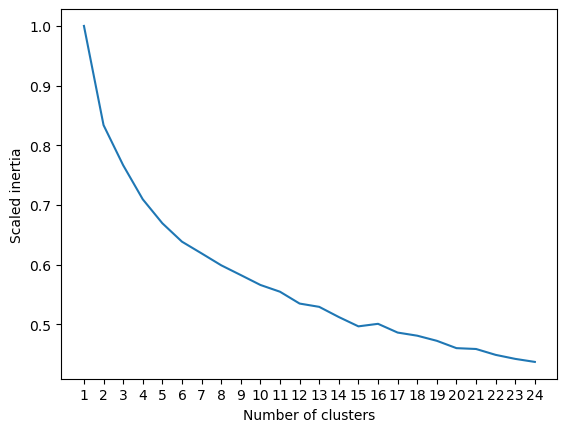

In [99]:
#inertia and elbow method
range_n_clusters = range(1, 25, 1)
inertia_vals = []
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    cluster_labels = clusterer.fit_predict(trace_X)
    inertia_vals.append(clusterer.inertia_)

#scale the inertia vals so that the first value is one
inertia_vals = np.array(inertia_vals)/inertia_vals[0]

#plot as a line plot
plt.plot(range_n_clusters, inertia_vals)
plt.xticks(range_n_clusters)
plt.xlabel("Number of clusters")
plt.ylabel("Scaled inertia")

#output inertia values
print(inertia_vals)

For n_clusters = 2 The average silhouette_score is : 0.14675220193316474
For n_clusters = 3 The average silhouette_score is : 0.13199876713932177
For n_clusters = 4 The average silhouette_score is : 0.11348042082732712
For n_clusters = 5 The average silhouette_score is : 0.10636560194011478
For n_clusters = 6 The average silhouette_score is : 0.10302124293197379


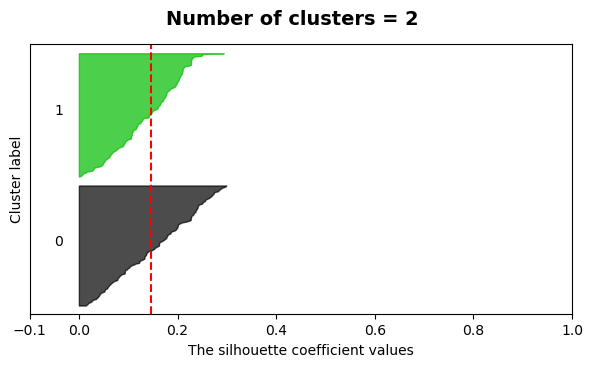

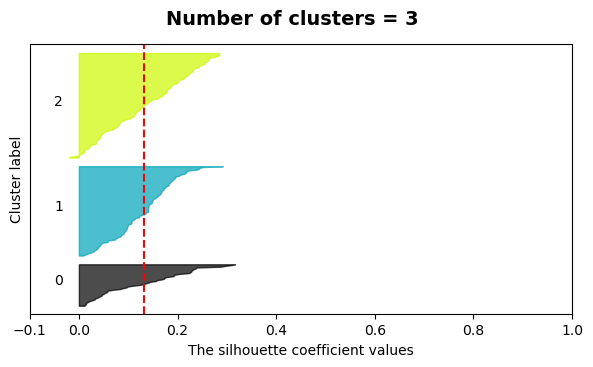

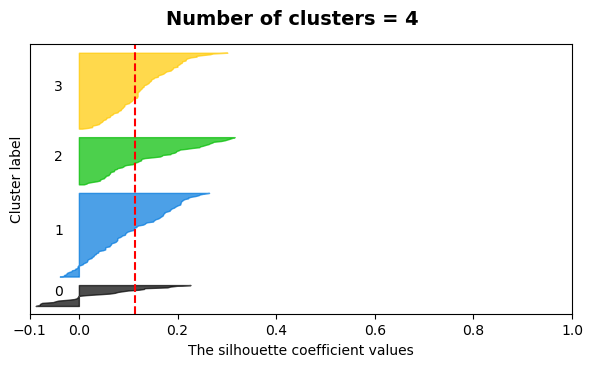

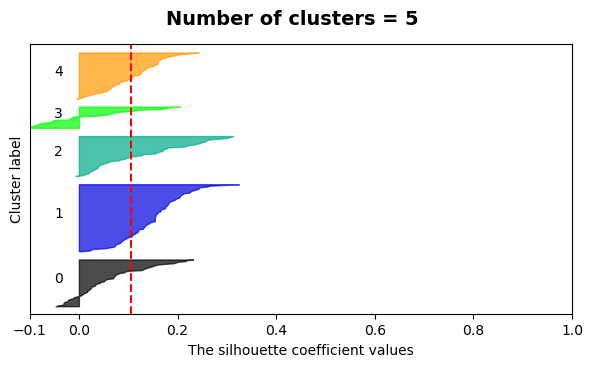

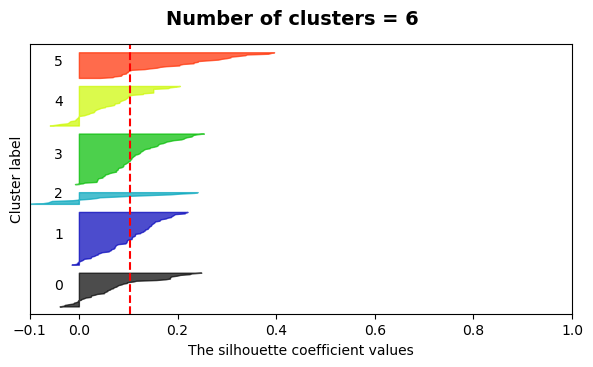

Text(0, 0.5, 'Silhouette Average')

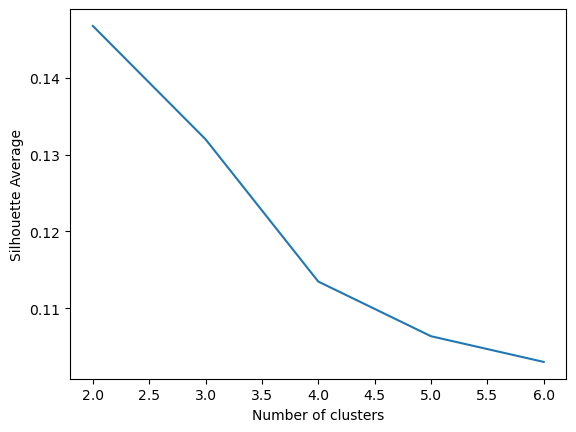

In [100]:
#next we consider three different methods for choosing the optimal number of clusters. If these dont perform well
#we will move onto the more complex approach of the gap statistic

#silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_list = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 3.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(trace_X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001,
                    verbose=0, random_state= 10, copy_x=True, algorithm='lloyd')
    #cluster_labels = clusterer.fit_predict(X)
    cluster_labels = clusterer.fit_predict(trace_X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(trace_X, cluster_labels)
    silhouette_avg_list.append(silhouette_avg)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trace_X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    plt.suptitle(
        #"Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        "Number of clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#also we plot just the average silhouette values by cluster number
plt.plot(range_n_clusters, silhouette_avg_list)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Average")

In [101]:
#next we want to apply k-means clustering with (euclidean distance measure) on our set of traces 
num_clusters = len(matchups)
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init= 'warn', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(trace_X)

In [102]:
#add kmeans cluster classifications of traces to dataframe 
extended_traces_flat['ClusterID'] = kmeans.labels_
strat_vs_clusterid = extended_traces_flat[['AgentName', 'AgentNameOpponent','ClusterID']]
counts = strat_vs_clusterid.groupby(['AgentName', 'AgentNameOpponent','ClusterID']).size()
print(counts)

AgentName                   AgentNameOpponent  ClusterID
4thEstate                   jacquilynne        0            1
                                               1            1
AhPro                       arpadTheGreat      1            1
Alan                        Mariah             1            1
Alphakiller                 J&D                1            1
                                                           ..
whisper                     doti               0            2
                                               1            1
♥~Pretty Pretty Princess~♥  bennu              1            2
                            ebEliminator       0            1
エム９                         Vqrpq              0            1
Length: 233, dtype: int64


In [103]:
def deck_evol_comparison(trace1, trace2, tag1, tag2, cardTypes, maxRounds, label1 = 'Trace1', label2 = 'Trace2'):
    #look at evolution of number of cards of each type per round
    noOfSubplotsInXDirection = 4
    noOfSubplotsInYDirection = 5
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection, figsize = (10,10))
    for i in range(0,noOfSubplotsInXDirection):
        for j in range(0,noOfSubplotsInYDirection):
            cardIndex = noOfSubplotsInXDirection*j + i
            if cardIndex >= 17:
                axs[1,4].set_visible(False)
                axs[2,4].set_visible(False)
                axs[3,4].set_visible(False)
                break
            cardType = cardTypes[cardIndex]
            card_col_1 = [cardType + "_R" + str(r) + tag1 for r in range(0,maxRounds)]
            card_col_2 = [cardType + "_R" + str(r) + tag2 for r in range(0,maxRounds)]
            axs[i,j].plot(range(0,maxRounds), trace1[card_col_1].iloc[0], label = label1)
            axs[i,j].plot(range(0,maxRounds), trace2[card_col_2].iloc[0], label = label2)
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            
            #set y limits 
            card_max1 = int(trace1[card_col_1].iloc[0].max())
            card_max2 = int(trace2[card_col_2].iloc[0].max())
            card_max = max(card_max1, card_max2)
            
            #pdb.set_trace()
            axs[i,j].set_ylim((0,card_max+2))
            axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    axs[0,4].legend(loc = (1.2,0.7))

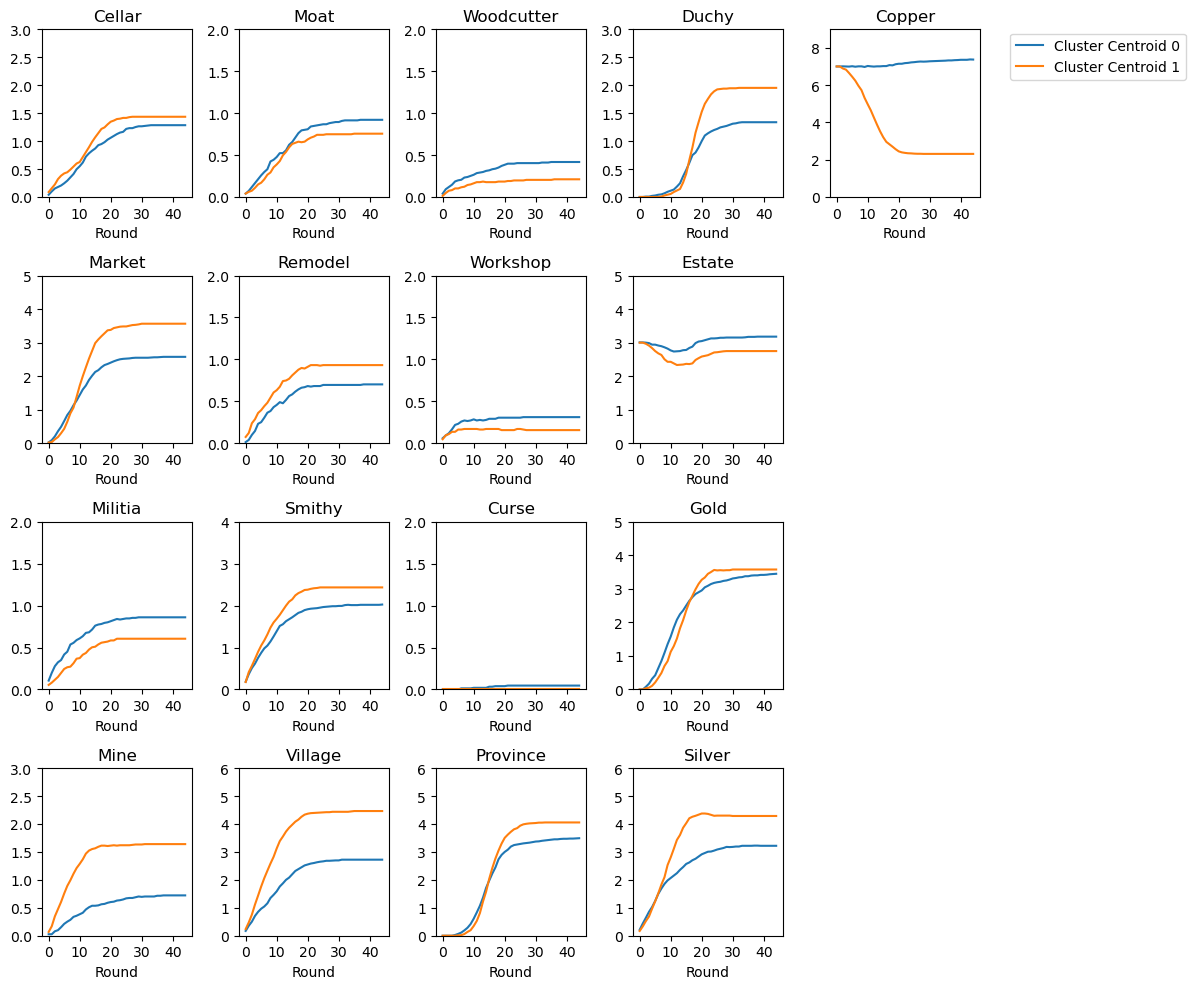

In [104]:
#compare centroids
df_cluster_centres = pd.DataFrame(kmeans.cluster_centers_)
cols = [card_types[i] + "_R" + str(r) for r in range(0, maxNoOfRounds) 
        for i in range(0, len(card_types))]
df_cluster_centres.columns = cols
cluster0centre = pd.DataFrame(df_cluster_centres.iloc[0]).transpose()
cluster1centre = pd.DataFrame(df_cluster_centres.iloc[1]).transpose()

deck_evol_comparison(cluster0centre, cluster1centre, "", "", card_types, maxNoOfRounds, 'Cluster Centroid 0', 
                     'Cluster Centroid 1')

In [105]:
#look a frequency of win rate and average final score by cluster
win_score = extended_traces_flat[['ClusterID', 'Win','FinalScore']]
means = win_score.groupby('ClusterID').mean()
print(means)

                Win  FinalScore
ClusterID                      
0          0.437086   29.284768
1          0.564626   32.931973


In [106]:
#look at player number by cluster - is it clustering by who goes first?
player_by_cluster = extended_traces_flat[['ClusterID', 'Player']]
player_mean = player_by_cluster.groupby('ClusterID').mean()
print(player_mean)

#Q: Does player zero always go first or does it swap half way through? If it doesn't swap, would the fact that cluster
#zero has a slightly higher incident of second player and slightly higher score account for the clustering?
#Impact of first player looks marginal

             Player
ClusterID          
0          0.562914
1          0.435374


In [107]:
#What kind of variation do we see in the evolution of the deck within a cluster?
def variation_by_card_type(data, tag, cardTypes, maxRounds):
    #look at max,min and average number of cards of each type per round
    noCardTypes = len(cardTypes)
    noOfSubplotsInXDirection = 4
    noOfSubplotsInYDirection = 5
    fig, axs = plt.subplots(noOfSubplotsInXDirection, noOfSubplotsInYDirection, figsize = (10,10))
    for i in range(0,noOfSubplotsInXDirection):
        for j in range(0,noOfSubplotsInYDirection):
            cardIndex = noOfSubplotsInXDirection*j + i
            if cardIndex >= 17:
                axs[1,4].set_visible(False)
                axs[2,4].set_visible(False)
                axs[3,4].set_visible(False)
                break
            cardType = cardTypes[cardIndex]
            avg_vals = []
            std_vals = []
            for r in range(0, maxRounds):
                col = cardType + "_R" + str(r) + tag
                avg_vals.append(data[col].mean())
                std_vals.append(data[col].std())
            
            #compute average plus or minus one standard deviation
            avg_minus_one_std = np.array(avg_vals) - np.array(std_vals)
            avg_minus_one_std = [max(0,x) for x in avg_minus_one_std]
            avg_plus_one_std = np.array(avg_vals) + np.array(std_vals)

            axs[i,j].plot(range(0,maxRounds), avg_vals, label = 'Average')
            axs[i,j].plot(range(0,maxRounds), avg_minus_one_std, label = 'Avg minus one std', linestyle = 'dashed')
            axs[i,j].plot(range(0,maxRounds), avg_plus_one_std, label = 'Avg plus one std', linestyle = 'dashed')
            axs[i,j].set_title(cardType)
            axs[i,j].set_xlabel('Round')
            axs[i,j].set_ylim((0,max(avg_plus_one_std)+1))
            axs[i,j].set_xticks(ticks = range(0, maxRounds,10))
            
            #tighten subplots layout
            fig.tight_layout() 
            
    #add overal legend to figure
    axs[0,4].legend(loc = (1.2,0.7))

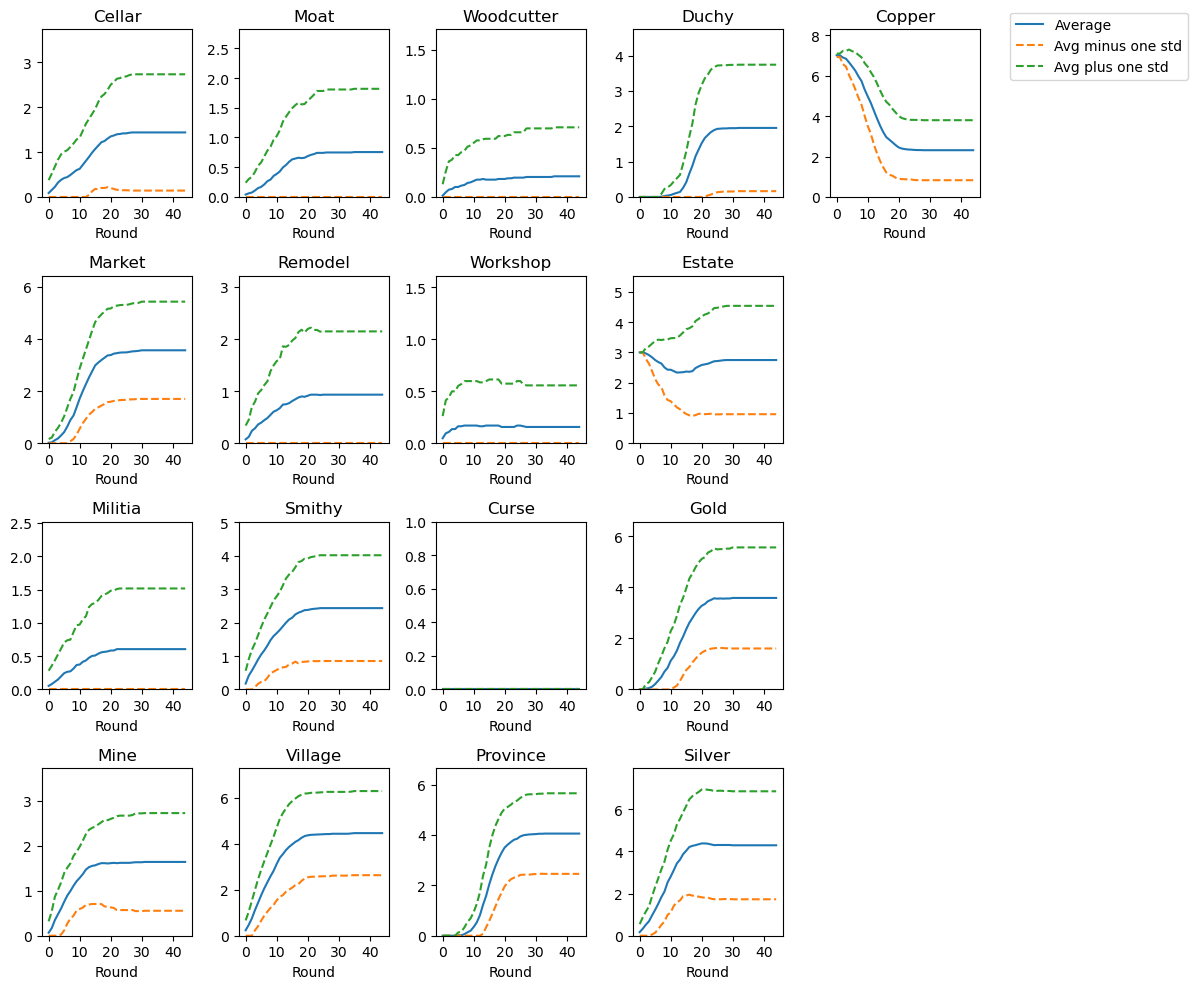

In [108]:
cluster_one_data = extended_traces_flat[extended_traces_flat['ClusterID'] == 1.0]
variation_by_card_type(cluster_one_data, "", card_types, maxNoOfRounds)

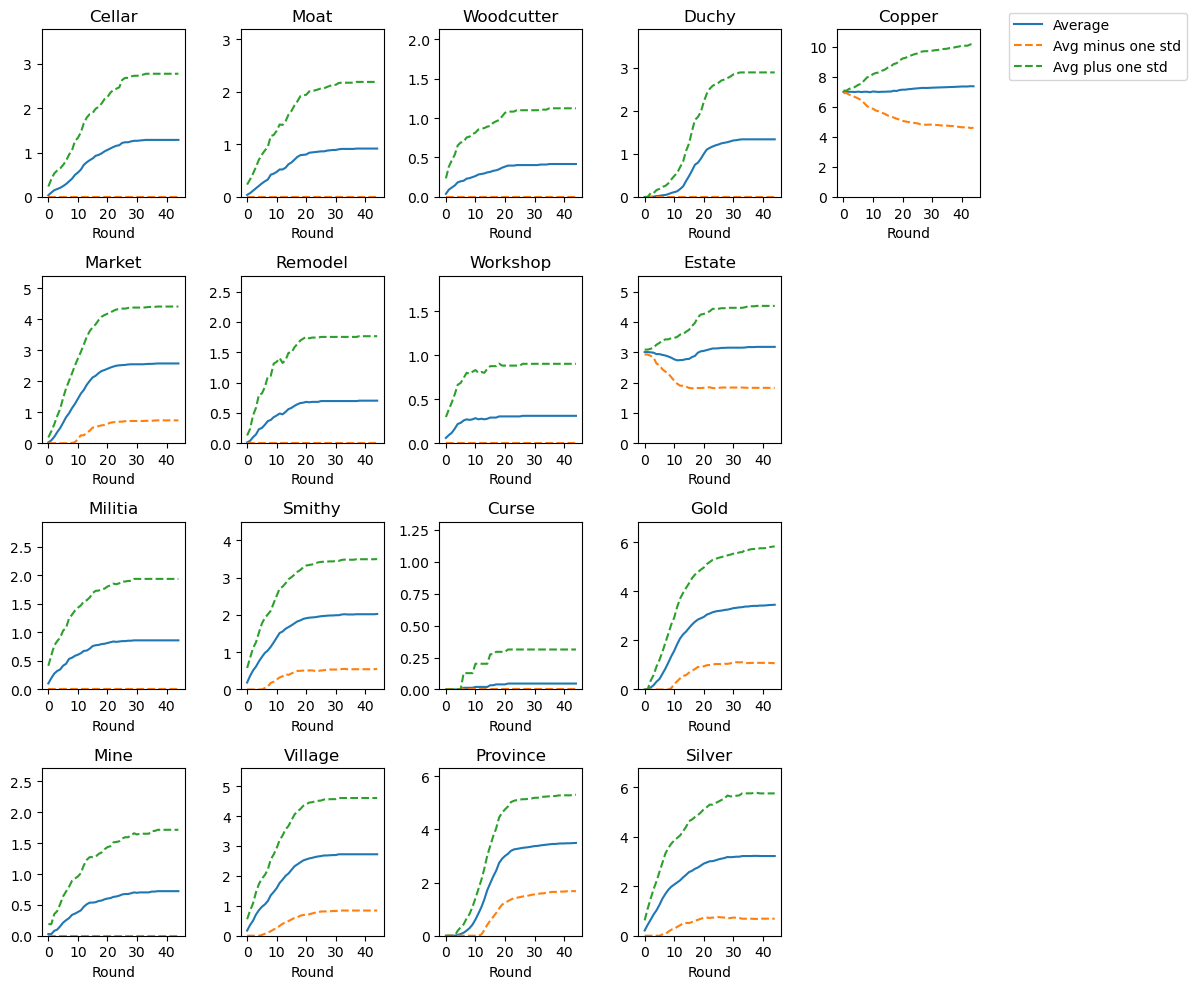

In [109]:
cluster_zero_data = extended_traces_flat[extended_traces_flat['ClusterID'] == 0.0]
variation_by_card_type(cluster_zero_data, "", card_types, maxNoOfRounds)

In [110]:
#compare evolution between clusters including error bounds
def variation_by_card_type_comparison(data1, data2, title1, title2, cardTypes, maxRounds):
    for card in cardTypes:
        fig, axs = plt.subplots(figsize = (9,5))
        datacounter = 0
        for data in [data1, data2]:
            title = title1
            linestyle_type = 'dotted'
            avg_color = 'darkgreen'
            std_color = 'green'
            if datacounter == 1:
                title = title2
                linestyle_type = 'dashed'
                avg_color = 'darkblue'
                std_color = 'blue'
            avg_vals = []
            std_vals = []
            for r in range(0, maxRounds):
                col = card + "_R" + str(r) 
                avg_vals.append(data[col].mean())
                std_vals.append(data[col].std())
                
            #compute average plus or minus one standard deviation
            avg_minus_one_std = np.array(avg_vals) - np.array(std_vals)
            avg_minus_one_std = [max(0,x) for x in avg_minus_one_std]
            avg_plus_one_std = np.array(avg_vals) + np.array(std_vals)
    
            axs.plot(range(0,maxRounds), avg_vals, color = avg_color, label = title + ' - Average')
            axs.plot(range(0,maxRounds), avg_minus_one_std, color = std_color, label = title + ' - Avg minus one std', linestyle = linestyle_type)
            axs.plot(range(0,maxRounds), avg_plus_one_std, color = std_color, label = title + ' - Avg plus one std', linestyle = linestyle_type)
            
            axs.set_title(card)
            axs.set_xlabel('Round')
            axs.set_xticks(ticks = range(0, maxRounds,10))
            axs.legend(loc = (1.1,0.68))
            datacounter += 1
        
        #tighten subplots layout
        #fig.ylim(0,5)
        fig.tight_layout() 
        #fig.legend(loc = (0.7,0.9))
        #fig.tight_layout() 
            
    #add overal legend to figure
    #axs[0,4].legend(loc = (1.2,0.7))

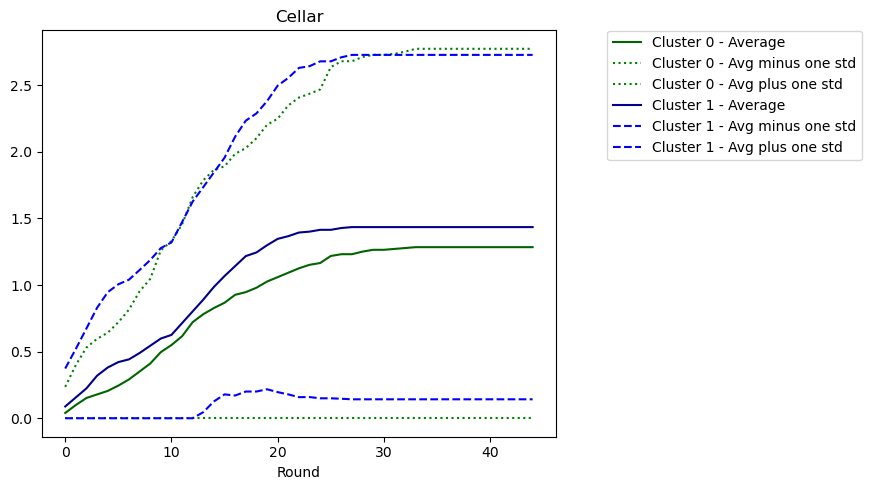

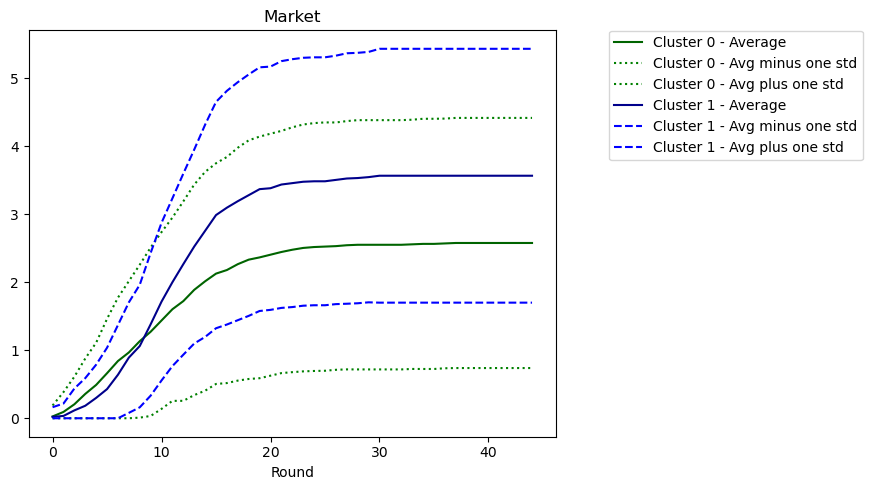

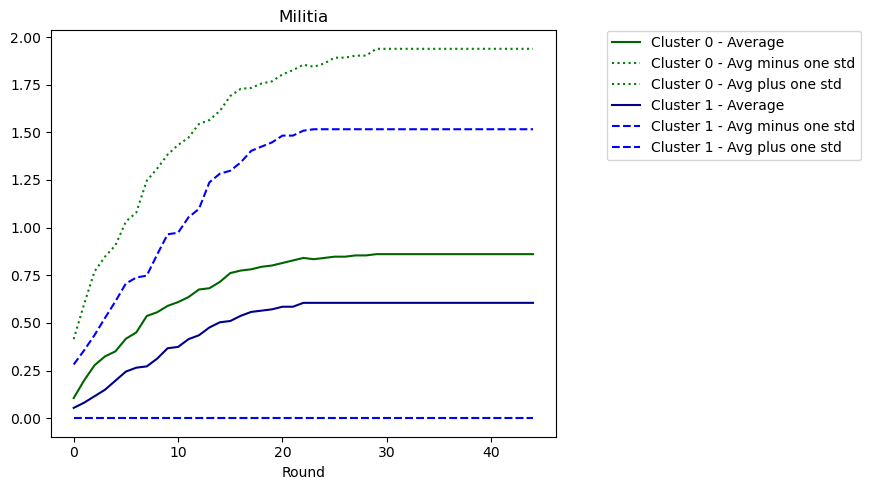

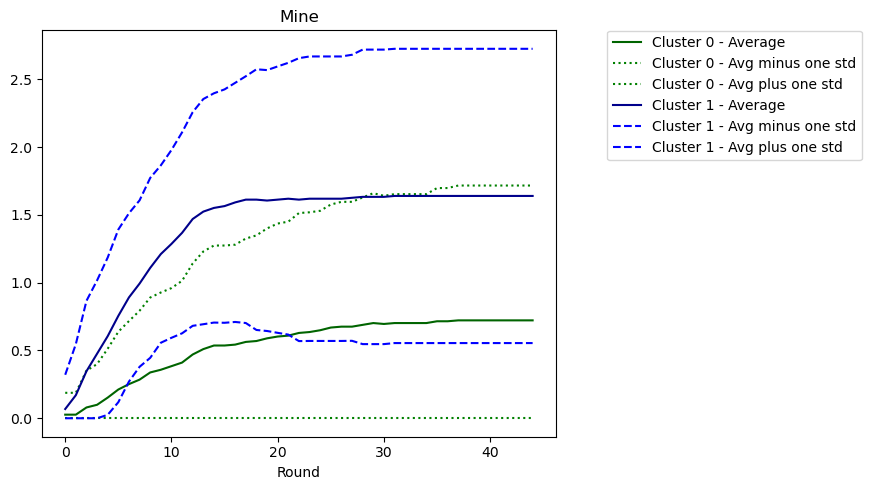

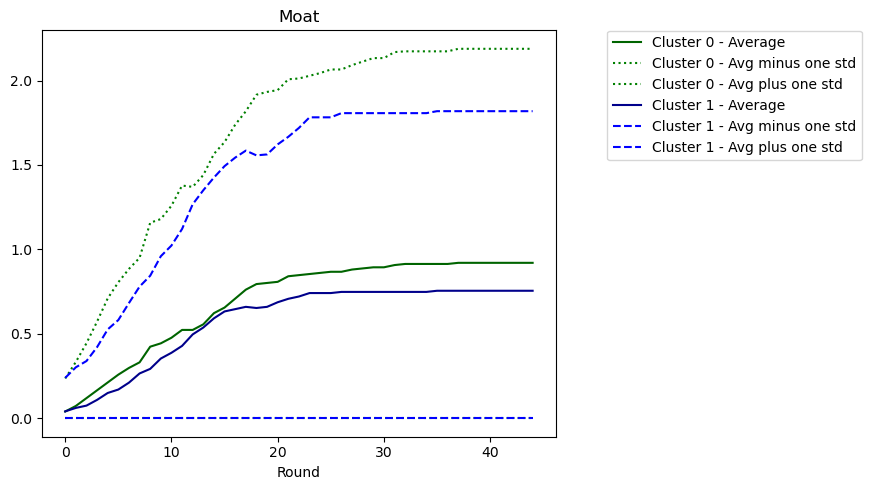

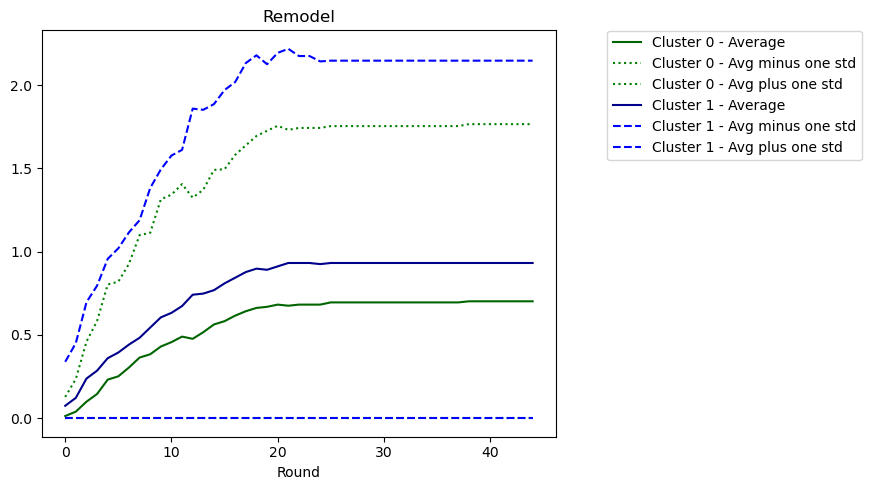

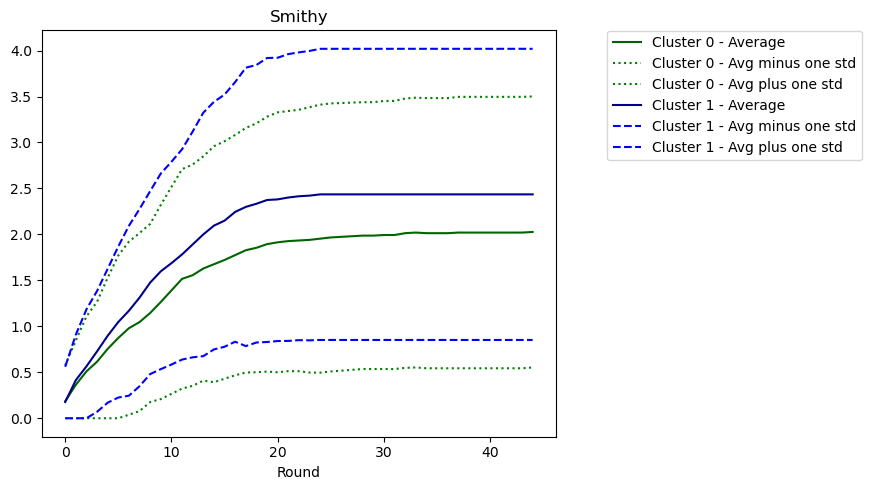

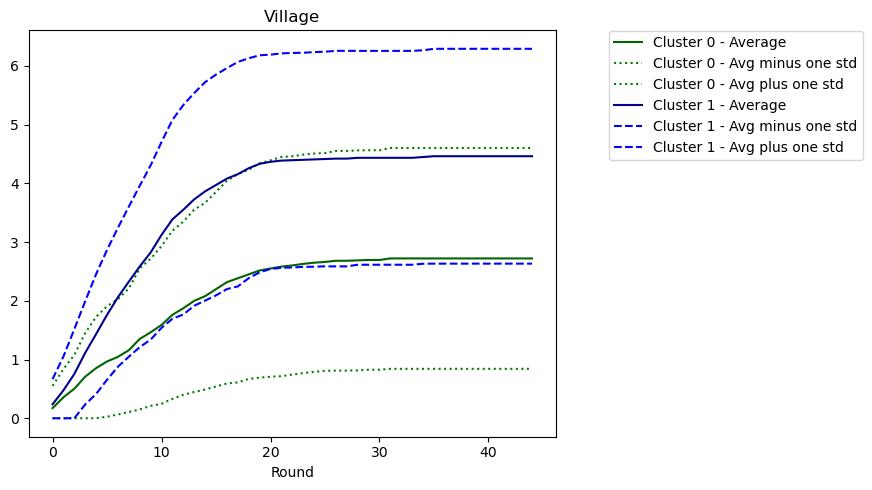

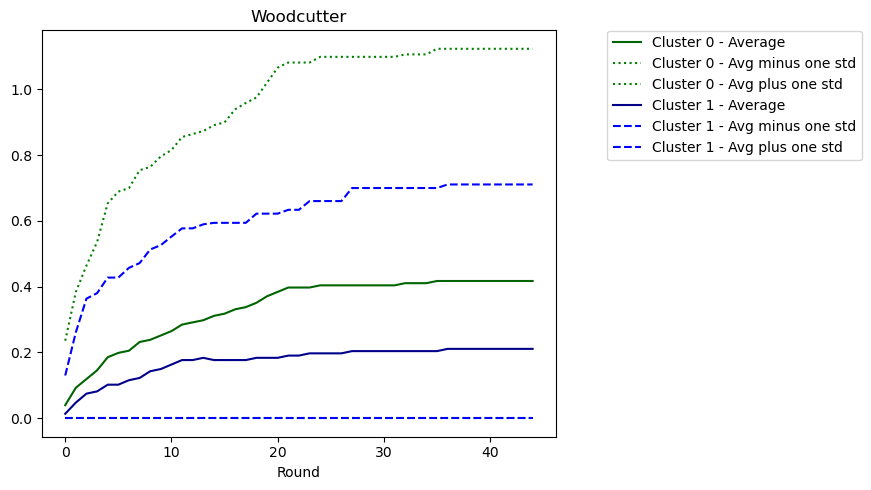

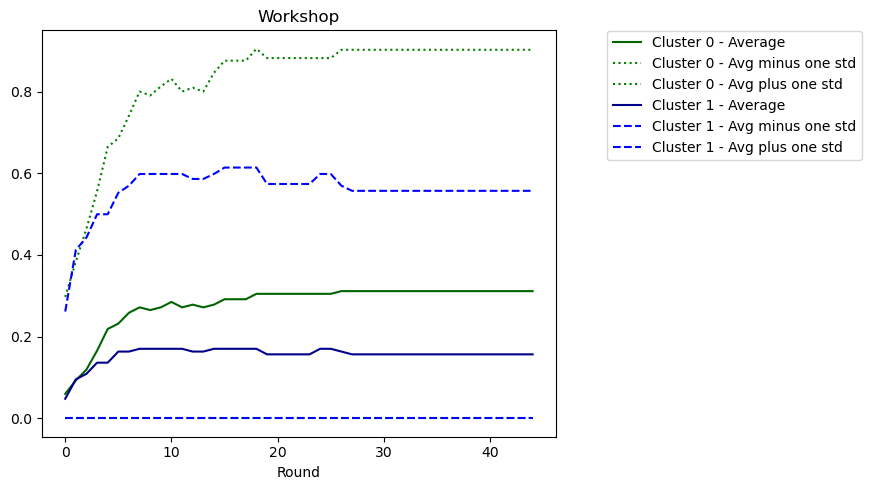

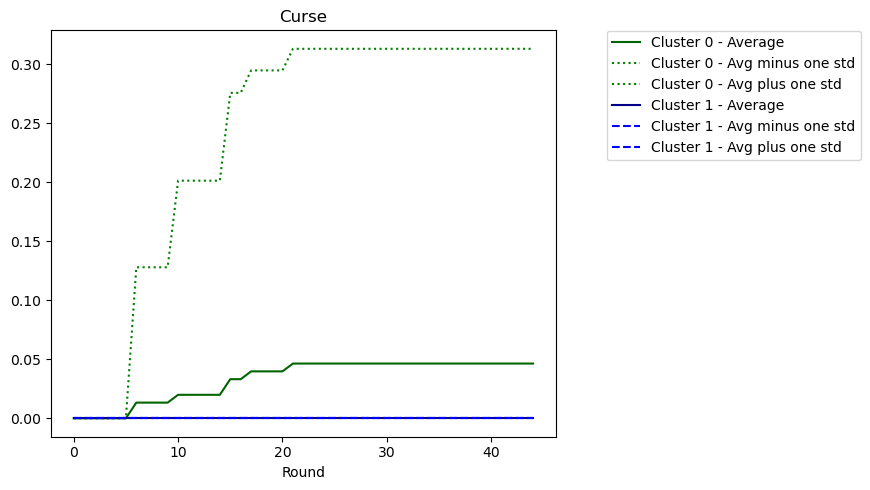

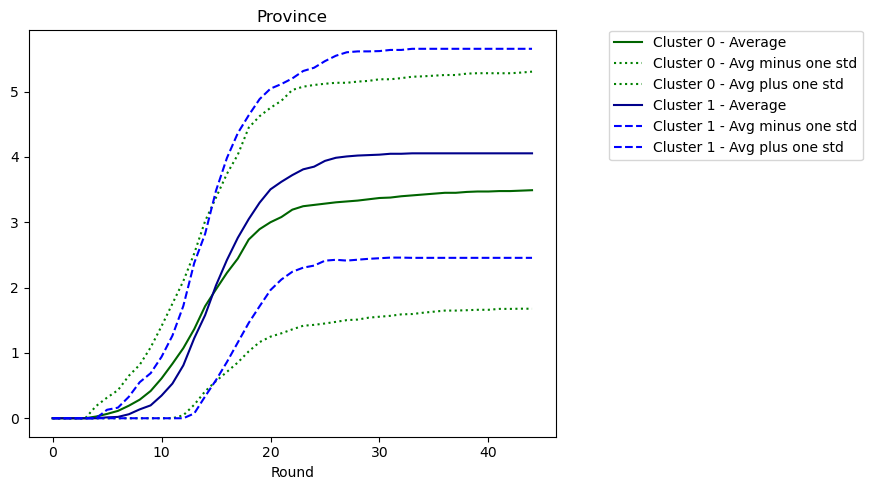

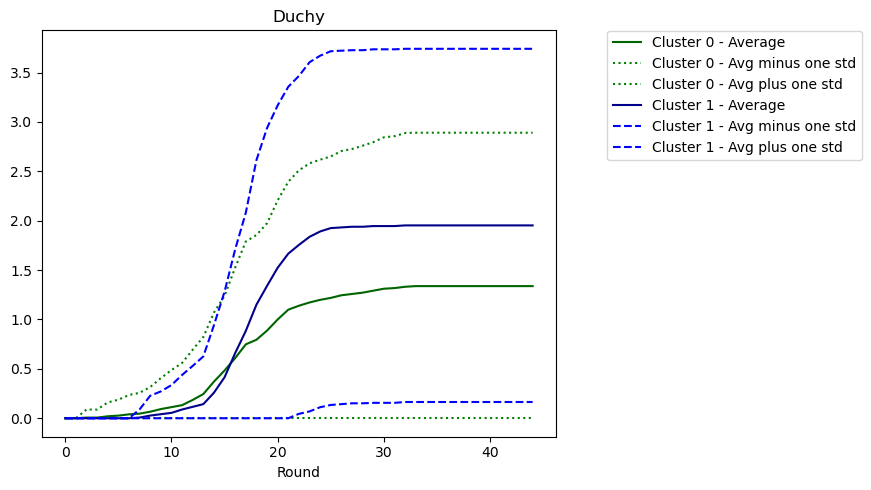

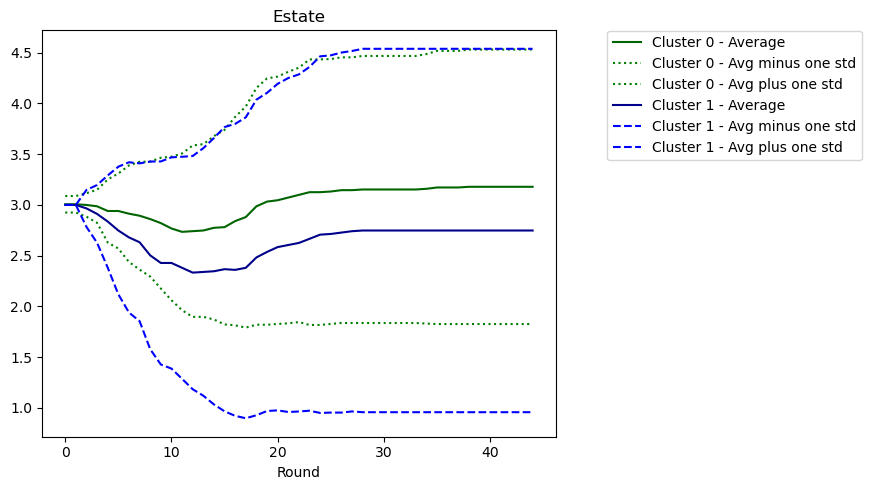

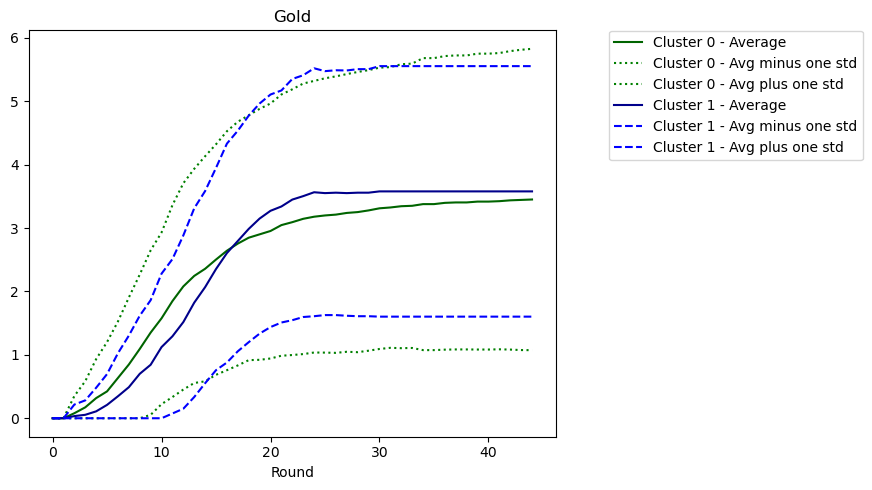

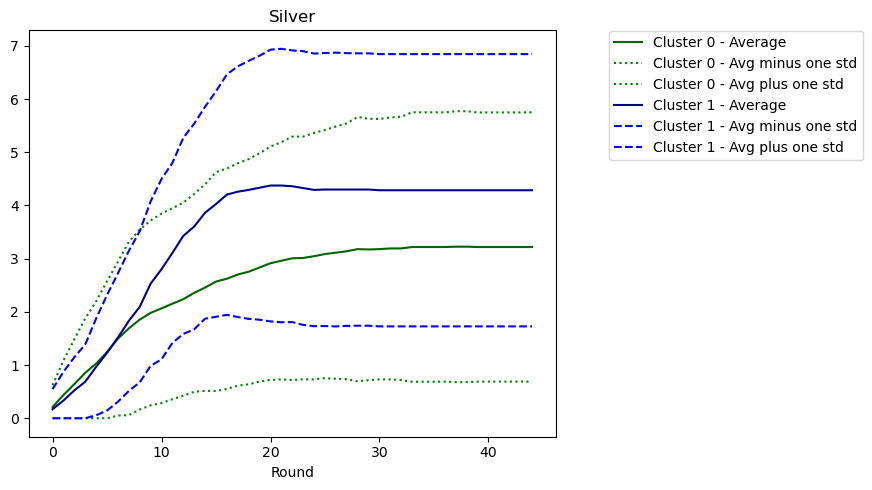

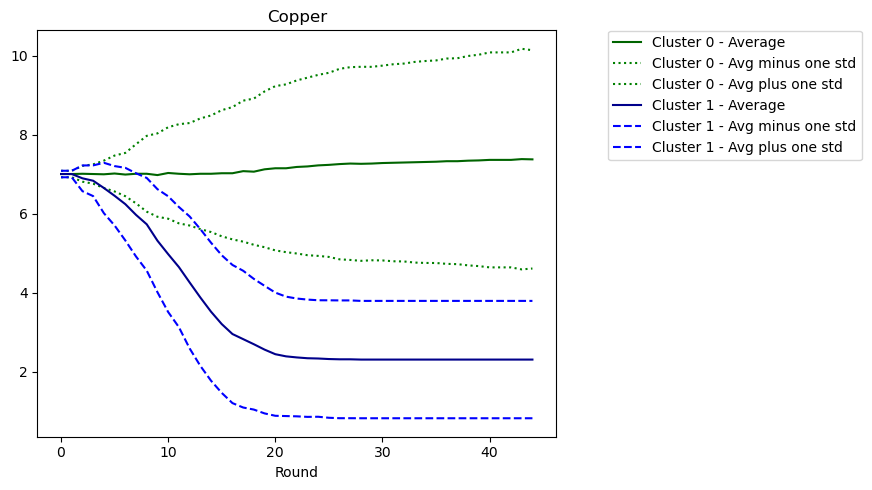

In [111]:
variation_by_card_type_comparison(cluster_zero_data, cluster_one_data, 'Cluster 0', 'Cluster 1', card_types, maxNoOfRounds)

In [31]:
#What are the unconditional probabilities of seeing a particular card in beginning, mid, late game?

In [32]:
#What are the conditional probabilities of seeing a particular card in beginning, mid, late game given another card exists
#in the deck?